In [1]:
%matplotlib inline

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

import pandas as pd
from Utils import *

from algorithms import *
from new_utils import *

# Comparison of algorithms for ordinal embedding

In [2]:
#Create data
dimensions= 15
number_of_points= 100

X = np.random.random((number_of_points, dimensions))
X = center_data(X)

In [3]:
n,d = X.shape
pulls = 1000
triplets, error = getTriplets(X, pulls)
    
print(ste_loss(X, triplets,1))

{'empirical_loss': 0.0, 'log_loss': 0.4058656908507961}


In [18]:
accuracy = 0.001

# Algorithms

In [19]:
# from projected_gradient import *

# M, loss, proj_grad_loss_arr = computeEmbedding(M0,
#                 n,
#                  d,
#                  triplets,
#                  num_random_restarts=0,
#                  max_iter_GD=500,
#                  max_norm=1,
#                  epsilon=0.0001,
#                  accuracy=accuracy, 
#                  verbose=False)



In [20]:
# from crowd_kernel import *

In [21]:
# X, emp_loss_train, projection_free_loss_arr = computeEmbedding(n,d,triplets,alpha=1,
#                                     num_random_restarts=0,
#                                     epsilon=0.0001,
#                                     accuracy = accuracy,
#                                     max_iters=100,
#                                     verbose=False)


In [ ]:
acc

In [4]:
X0 = np.random.random((n,d))
# X0 = X
print(ste_loss(X0, triplets, 1))
stats = triplet_algorithms(ste_loss, 
                   triplets,
                   X0,                       
                   d,
                   'full_grad', 
                   11,
                   iters=50,
                   epsilon = accuracy,
                   proj=None)

{'empirical_loss': 0.483, 'log_loss': 0.7954863015055513}


NameError: name 'accuracy' is not defined

In [23]:
M0 = np.random.randn(n,n)
# M0 = (M+M.transpose())/2
# M0 = M - 1.0/n*dot(ones((n,n)),M)
# print(M0)
print(ste_loss_convex(M0, triplets, 1))



{'log_loss': 1.5184573841393774, 'empirical_loss': 0.502}


In [24]:
stats2 = triplet_algorithms(ste_loss_convex, 
                   triplets,
                   M0,                       
                   d,                            
                   'full_grad', 
                    1000,
                   iters=100,
                   epsilon = accuracy,
                   proj=projected)

0.502
Accuracy reached in 10 iterations


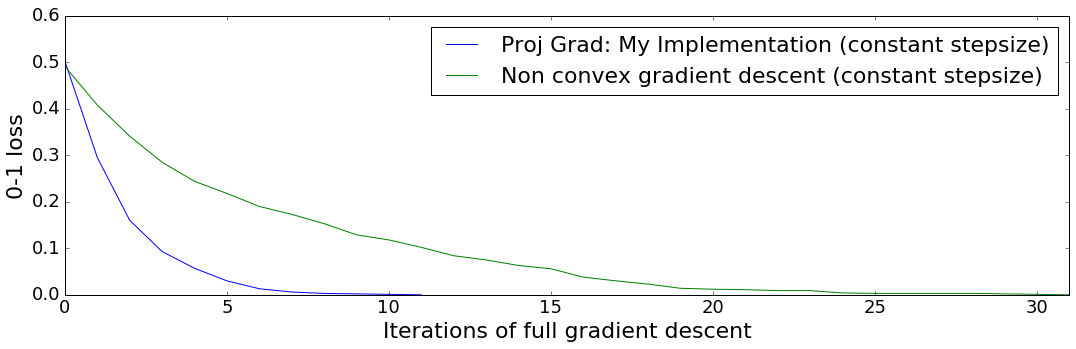

In [26]:
df = pd.DataFrame([stats2['emp'],
                   stats['emp'],
#                    proj_grad_loss_arr 
                  ]
                 ).T
df.columns = ['Proj Grad: My Implementation (constant stepsize)',
              'Non convex gradient descent (constant stepsize)', 
#               'Proj Grad: Next Implementation (backtracking)'
             ]

ax = df.plot(figsize=(18,5), fontsize=18)
ax.set_ylabel('0-1 loss', fontsize=22)
ax.set_xlabel('Iterations of full gradient descent', fontsize=22)
ax.legend(fontsize=22);

In [28]:
# SGD
# SVRG
# Franke Wolfe

stats['time_per_iter']

[0.2023618221282959,
 0.2048780918121338,
 0.2136831283569336,
 0.18268179893493652,
 0.19855093955993652,
 0.18567490577697754,
 0.1823279857635498,
 0.1813068389892578,
 0.1820828914642334]

In [14]:
pd.DataFrame([stats2['emp'], proj_grad_loss_arr]).T

,0,1
0,0.502,0.502
1,0.341,0.484
2,0.210,0.484
3,0.136,0.484
4,0.094,0.484
5,0.065,0.484
6,0.039,0.483
7,0.032,0.480
8,0.021,0.479
9,0.012,0.476
